# Setting Up Modules to Circumvent Conflicts

In [1]:
!pip uninstall numpy
!pip install numpy==1.23.1

Found existing installation: numpy 1.23.1
Uninstalling numpy-1.23.1:
  Would remove:
    /usr/local/bin/f2py
    /usr/local/bin/f2py3
    /usr/local/bin/f2py3.11
    /usr/local/lib/python3.11/dist-packages/numpy-1.23.1.dist-info/*
    /usr/local/lib/python3.11/dist-packages/numpy/*
Proceed (Y/n)? Y
  Successfully uninstalled numpy-1.23.1
  Using cached numpy-1.23.1-cp311-cp311-linux_x86_64.whl
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pandas-stubs 2.2.2.240909 requires numpy>=1.23.5, but you have numpy 1.23.1 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.23.1 which is incompatible.
albumentations 2.0.8 requires numpy>=1.24.4, but you have numpy 1.23.1 which is incompatible.
pandas 2.2.2 requires numpy>=1.23.2; python_version == "3.11", but you have numpy 1.23.1 which is incompatible.
treescope 0.1.9 requires numpy>=

# Preliminary Code Blocks

In this section, we provide the C based code blocks that are the primary base for our experiments. There are two main code blocks,
1. Stochastic: where only the distribution of the income and the returns are known.
2. Lookahead: where we provide furture information for a fixed horizon.

## Stochastic

In [1]:
%%writefile stochastic.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>

//To change init_assets, yrng, yrng2, lookahead
//Initial setup
int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float R[50]; // Real return values
float Y[50]; // Real income values
float S[50]; // Real shock values
float B[50]; // Minimum subsistence values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {1.2,1.5}; // Nominal income range
float yrng2[2] = {0,0}; // Nominal income range
float yshocks[2] = {-0.3,0.3};
float brng[2] = {30,70};
float YM = 7; // Income upper bound
float Ym = 0; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 0;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int seed = 1111;
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
  float p = 0.5;
  return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            if(constmp>x){
              constmp = x;
            }
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float rtn = R[t-1];
              if(j<n){
              	rtn = (rng[0]+((float)rand() / (float)RAND_MAX)*(rng[1]-rng[0]));
              }
              for(int i=0; i<=n; i++){
                float inc = Y[t-1];
                if(i<n){
              		inc = (yrng[0]+((float)rand() / (float)RAND_MAX)*(yrng[1]-yrng[0]));
              	}
                if(value[t][getListIndex((int)((rtn)*(x-constmp)+(inc)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((rtn)*(x-constmp)+(inc)));
                }
                s+=value[t][getListIndex((long long)((rtn)*(x-constmp)+(inc)), lowvl)];

              }
            }
            float ex = s/(n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
        valon[tl-ts][getListIndex(x, lowvl)] = bst;
        solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[tl-1]){
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		      solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[tl-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[tl-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        if(constmp>x){
          constmp = x;
        }
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[t-1]){
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		      solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[t-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[t-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        if(constmp>x){
          constmp = x;
        }
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
        if(x>=B[t-1]){
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		      solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
        }else{
          valon[t-ts][getListIndex(x, lowvl)] = utility(0);
		      solon[t-ts][getListIndex(x, lowvl)] = 0;
        }
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  FILE *fp3;
  FILE *fp5;
  FILE *fp6;
  FILE *fp7;
  fp3 = fopen("/content/RuntimeData-Online-Normal-Setup-R.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp3,"%f,",R[i]);
  }
  fp5 = fopen("/content/RuntimeData-Online-Normal-Setup-Y.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp5,"%f,",Y[i]);
  }
  fp6 = fopen("/content/RuntimeData-Online-Normal-Setup-B.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp6,"%f,",B[i]);
  }
  fp7 = fopen("/content/RuntimeData-Online-Normal-Setup-S.csv","w+");
  for(int i=0;i<T;i++){
  	fprintf(fp7,"%f,",S[i]);
  }
  fclose(fp3);
  fclose(fp5);
  fclose(fp6);
  fclose(fp7);
  DPStochastic(1, x);
  FILE *fp1;
  fp1 = fopen("/content/RuntimeData-Online-Normal-Stochastic-Value.csv", "w+");
  FILE *fp2;
  fp2 = fopen("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv", "w+");
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
    	fprintf(fp1,"%f,",value[i][j]);
		fprintf(fp2,"%f,",cons[i][j]);
    }
    fprintf(fp1,"\n");
	fprintf(fp2,"\n");
  }
  fclose(fp1);
  fclose(fp2);

  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }

void generateR(void){
    srand(seed); // randomize seed
    for(int i=0;i<T;i++){
      if(get_random()>0.9){
        R[i] = rng[0]+get_random()*(rng[1]-rng[0])+(rng2[0]+get_random()*(rng2[1]-rng2[0])); // Generate a shock value with 0.1 prob.
      }else{
        R[i] = (rng[0]+get_random()*(rng[1]-rng[0]));
      }
    }
}

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}

float basic_expenditure(float income){
    float basic_needs = 0;
    income = 4*income;
    if(income <= 1.2568260226625605){
        basic_needs = 25856/12;
    }else if(income <= 2.1841808609145184){
        basic_needs = 31499/12;
    }else if(income<= 3.1160042501484027){
        basic_needs = 37131/12;
    }else if(income <= 4.237546534052588){
        basic_needs = 43822/12;
    }else if(income <=5.396604512183551){
        basic_needs = 49367/12;
    }else if(income <=6.790213433512611){
        basic_needs = 56720/12;
    }else if(income <=8.564621039595588){
        basic_needs = 66435/12;
    }else if(income <=11.194399946842418){
        basic_needs = 75945/12;
    }else if(income <=16.030104407593548){
        basic_needs = 96913/12;
    }else{
        basic_needs = 145967/12;
    }
    return basic_needs/4000;
}

int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  yrng[0] = atof(argv[2]);
  yrng[1] = atof(argv[3]);
  rng[0] = atof(argv[4]);
  rng[1] = atof(argv[5]);
  yshocks[0] = atof(argv[6]);
  yshocks[1] = atof(argv[7]);
  beta = atof(argv[8]);
  seed = atoi(argv[9]);
  generateR();
  srand(seed);
  for(int i=0;i<T;i++){
  	if(get_random()>0.6){
    	Y[i] = yrng[0]+get_random()*(yrng[1]-yrng[0]);
      S[i] = ((yshocks[0]+get_random()*(yshocks[1]-yshocks[0])))*Y[i];
      Y[i] = (1+(yshocks[0]+get_random()*(yshocks[1]-yshocks[0])))*Y[i];
    }else{
    	Y[i] = yrng[0]+get_random()*(yrng[1]-yrng[0]);
      S[i] = 0;
    }
  }
  for(int i=0;i<T;i++){
  	B[i] = basic_expenditure(Y[i]);
  }
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}


Overwriting stochastic.c


## Lookahead

In [2]:
%%writefile lookahead.c
#include <stdio.h>
#include <math.h>
#include <time.h>
#include <stdlib.h>
#include <string.h>

int T = 26; //Time of death
long long init_assets = 24.13; //Initial assets level
long long D; //Number of buckets
float **value; //Array to contain all the optimal values
float **cons; //Array to contain all the consumption values
float **valon; //Array to contain all the optimal values
float **solon; //Array to contain all the consumption values
float *R; // Real return values
float *Y; // Real income values
float *B; // Real income values
float rng[2] = {0.9,1.1}; // Nominal return range
float rng2[2] = {-0.05,0.05}; // Return range for shocks (currently set to be the same)
float yrng[2] = {50,60}; // Nominal income range
float yrng2[2] = {-10,10}; // Nominal income range
float brng[2] = {30,70};
float YM = 70; // Income upper bound
float Ym = 40; // Income lower bound
float RM = 1.15; // Return upper bound
float Rm = 0.85; // Return lower bound
float beta = 0.95; // Beta value
int ns = 10;
int lookahead = 0;
float granularity = 1;
long long lowvl; // Lowest possible asset values
int heightG = 0;
int widthG = 0;

/*
Dynamic memory allocation
*/
float **malloc2dCArray (int nRows, long long nCols)
{
    float **pArray = malloc (sizeof(float *) * nRows + sizeof(float) * nCols * nRows);

    if (pArray) {
        float *pOffset = (float *)(pArray + nRows);
        int   i;
        for (i = 0; i < nRows; i++) {
            pArray[i] = pOffset;
            pOffset += nCols;
        }
    }
    return pArray;
}
/*Return the max of two elements*/
float maxValue(float v1, float v2){
  if(v1>=v2){
    return v1;
  }
  return v2;
}

/*Return the min of two elements*/
float minValue(float v1, float v2){
  if(v1>=v2){
    return v2;
  }
  return v1;
}

void getFileInfo(char* filename){
	FILE* f = fopen(filename, "r");
	int height = 0, width = 0;
	char c;
	for (c = getc(f); c != EOF; c = getc(f)){
		if (c == '\n'){
			height++;
		}
		if ((c == ',') && (height == 0)){
			width++;
		}
    }
	widthG = width;
	heightG = height;
	printf("Height: %d and Width: %d\n", heightG, widthG);
	fclose(f);
}

float **readFile(char* filename){
	getFileInfo(filename);
	float **value_tmp = malloc2dCArray (heightG, widthG);
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii, jj;
    float tmp;
    for(jj=0; jj<heightG; jj++){
        for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[jj][ii] = tmp;
        }
    }
    fclose(f);
    return value_tmp;
}

float *readFileVector(char* filename){
	getFileInfo(filename);
	float *value_tmp = malloc(sizeof(float) * widthG);;
	//value = value_tmp;
	FILE* f = fopen(filename, "r");
	int ii;
    float tmp;
    for(ii=0; ii<widthG; ii++){
            fscanf(f, "%f,", &tmp);
            value_tmp[ii] = tmp;
    }
    fclose(f);
    return value_tmp;
}
/*
Given the value return dynamic index. If -100<=x<=100, the value is set to x
and otherwise if x is a10^y+b then it is mapped to the floor of (x-10^y)/5^(y-2).
This will ensure we will miss only 5% of the assets and thus a minimal deviation.
*/

long long getIndex(long long x){
  if(x>=0){
    int d = floor(log10(x));
    if(d>=2){
      return 99+((int)(900/granularity))*(d-2)+floor((x-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1;
    }else{
      return x;
    }
  }else{
    long long y = -1*x;
    int d = floor(log10(y));
    if(d>=2){
      return -1*(99+((int)(900/granularity))*(d-2)+floor((y-(long long)pow(10,d))/(granularity*pow(10,d-2)))+1);
    }else{
      return x;
    }
  }
}

/*
int getIndex(long long x){
  return (int)x;
}
*/
/*
Get the index and offset using the index of the lowest value, i.e. offsetting to zero
*/
long long getListIndex(long long x, long long low){
  if(x>=0){
  	return getIndex(x)-getIndex(low);
  }else{
  	return 0;
  }
}

/*
Revesre the process of index calculation and get the original value upto 5% error
*/
long long getOrigIndexList(long long x, long long low){
  x = x+getIndex(low);
  if(x>=0){
    if(x<=100){
      return x;
    }else{
      long long tmp = x-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)((granularity*pow(10,d-2))*(x-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d));
    }
  }else{
    if(x>=-100){
      return x;
    }else{
      long long y = -1*x;
      long long tmp = y-100;
      int d = 2+floor(tmp/((int)(900/granularity)));
      return (long long)(-1*((granularity*pow(10,d-2))*(y-100-((int)(900/granularity))*(d-2))+(long long)pow(10,d)));
    }
  }
}

float utility(float c){
	float p = 0.5;
	return powf(c,p);
}
/*
Stochastic dynamic program.
*/
void DPStochastic(int t, long long x){
    printf("t=%d, x=%lld\n",t,x);

    if(t==T){
        /* If the time is at an end consume everything */
        value[t-1][getListIndex(x, lowvl)] = utility(x);
        cons[t-1][getListIndex(x, lowvl)] = x;
    }else{
        long long ubnd = (long long)(R[t-1]*x+Y[t-1])+1; // Highest possible next asset value
        long long lbnd = (long long)0; // Lowest possible next asset value
        long long indubnd = getListIndex(ubnd, lowvl); // Index of the upper bound
        long long indlbnd = getListIndex(lbnd, lowvl); // Index of the lower bound

        for(long long i=indlbnd; i<=indubnd; i++){
          /*
          For each entry in the index range, try to calculate the values and consumptions.
          This is because we do not know the path and thus we need to see the entire scope of the solution space.
          */
          if(value[t][i]<0){
            DPStochastic(t+1,getOrigIndexList(i, lowvl));
          }
        }
        if(value[t-1][getListIndex(x, lowvl)]<0){
          long long tx = x;
          if(x<=0){
            tx = 0;
          }
          float tmp = 0;
          float bst = 0;
          float bstcon = 0;
          long long indtx = getListIndex((int)tx, lowvl);
          long long indst = getListIndex(0, lowvl);
          // Calculating the consumption by iterating over all possible values and picking the best
          for(long long k=indst; k<=indtx;k++){
            long long constmp = getOrigIndexList(k, lowvl);
            long long ubnd = (long long)(RM*(x-constmp)+YM)+1;
            long long lbnd = (long long)Ym;
            int n = 10;
            float s = 0;
            float dY = (YM-Ym)/n;
            float dR = (RM-Rm)/n;
            /* Calculating the expected value using Simpson's rule on return and income */
            for(int j=0; j<=n;j++){
              float c = 0;
              for(int i=0; i<=n; i++){
                if(value[t][getListIndex((int)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)]<0){
                  DPStochastic(t+1,(long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)));
                }
                if(i==0 || i==n){
                  c+=value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                }else{
                  if(i%2==0){
                    c+=2*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }else{
                    c+=4*value[t][getListIndex((long long)((Rm+j*dR)*(x-constmp)+(Ym+i*dY)), lowvl)];
                  }
                }
              }
              if(j==0 || j==n){
                s+=c;
              }else{
                if(j%2==0){
                  s+=2*c;
                }else{
                  s+=4*c;
                }
              }
            }
            float ex = s/(9*n*n);
            /* End of expectation calculation */
            tmp = utility(constmp) + beta*ex;
            if(tmp>bst){
              bst = tmp;
              bstcon = constmp;
            }
          }
          value[t-1][getListIndex(x, lowvl)] = bst;
          cons[t-1][getListIndex(x, lowvl)] = bstcon;
        }
    }
}

void OnlineDP(long long x,int t,int tl,int ts){
  //printf("%d\n",t-ts);
  if(tl<T){
    if(t==tl){

      float bst = 0;
      float bstcon = 0;
      bstcon = cons[tl-1][getListIndex(x, lowvl)];
      bst = value[tl-1][getListIndex(x, lowvl)];
      if(bstcon>=B[tl-1]){
		  valon[tl-ts][getListIndex(x, lowvl)] = bst;
		  solon[tl-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[tl-1]*(x-B[tl-1])+Y[tl-1]);
          float tmp = utility(B[tl-1]) + beta*value[tl-ts+1][getListIndex(r, lowvl)];
      	  valon[tl-ts][getListIndex(x, lowvl)] = tmp;
		  solon[tl-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      if(x<0){
      	indtx = getListIndex(0, lowvl);
      }
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }else{
    if(t==T){
    	if(x<=0){
    		valon[t-ts][getListIndex(x, lowvl)] = utility(0);
      		solon[t-ts][getListIndex(x, lowvl)] = 0;
    	}else{
    		valon[t-ts][getListIndex(x, lowvl)] = utility(x);
      		solon[t-ts][getListIndex(x, lowvl)] = x;
    	}

    }else{
      long long indtx = getListIndex((long long)x, lowvl);
      long long indst = getListIndex(0, lowvl);
      float tmp = 0;
      float bst = 0;
      float bstcon = 0;
      for(long long k=indst; k<=indtx;k++){
        long long constmp = getOrigIndexList(k, lowvl);
        long long r = (long long)(R[t-1]*(x-constmp)+Y[t-1]);
        if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
            OnlineDP(r,t+1,tl,ts);
        }
        tmp = utility(constmp) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
        if(tmp>bst){
            bst = tmp;
            bstcon = constmp;
        }
      }
      if(bstcon>=B[t-1]){
		  valon[t-ts][getListIndex(x, lowvl)] = bst;
		  solon[t-ts][getListIndex(x, lowvl)] = bstcon;
      }else{
      	  long long r = (long long)(R[t-1]*(x-B[t-1])+Y[t-1]);
      	  if(valon[t-ts+1][getListIndex(r, lowvl)]<0){
              OnlineDP(r,t+1,tl,ts);
          }
          float tmp = utility(B[t-1]) + beta*valon[t-ts+1][getListIndex(r, lowvl)];
      	  valon[t-ts][getListIndex(x, lowvl)] = tmp;
		  solon[t-ts][getListIndex(x, lowvl)] = B[t-1];
      }
    }
  }
}

void trackConsumption(FILE *fp, FILE *fp1, long long x, int t, int tl){
	float c = 0;
	if(tl>T){
		tl=T;
	}
	for(int i=0;i<=tl-t;i++){
		 c = solon[i][getListIndex(x, lowvl)];
		 fprintf(fp1,"%lld,",x);
		 fprintf(fp,"%lld,",getListIndex(x, lowvl));
		 x = (long long)(R[t+i-1]*(x-c)+Y[t+i-1]);
	}
	fprintf(fp1,"%lld\n",x);
	fprintf(fp,"%lld\n",getListIndex(x, lowvl));
}

void OnlineConsumption(long long x, int lookahead){
  value = readFile("/content/RuntimeData-Online-Normal-Stochastic-Value.csv");
  cons = readFile("/content/RuntimeData-Online-Normal-Stochastic-Solution.csv");
  FILE *fp3,*fp4,*fp5;
  char lookid[5];
  sprintf(lookid,"%d",lookahead);
  char filename[60];
  snprintf(filename,sizeof(filename),"%s%s%s", "/content/RuntimeData-Online-Normal-", lookid,".CSV");
  fp3 = fopen(filename, "w+");
  fp4 = fopen("/content/RuntimeData-Online-Assets.csv", "a+");
  fp5 = fopen("/content/RuntimeData-Online-Consumption.csv", "a+");
  for(int t=1;t<=T;t++){
  	int tl = t+lookahead;
  	if(tl>T){
  		tl=T;
  	}
    OnlineDP(x,t,tl,t);
    fprintf(fp3, "%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    printf("%f,%lld,%f,%f,%f,%f \n",R[t-1],x,solon[0][getListIndex(x, lowvl)],Y[t-1],valon[0][getListIndex(x, lowvl)],utility(solon[0][getListIndex(x, lowvl)]));
    fprintf(fp4,"%lld,",x);
    fprintf(fp5,"%f,",solon[0][getListIndex(x, lowvl)]);
    x = (long long)(R[t-1]*(x-solon[0][getListIndex(x, lowvl)])+Y[t-1]);
    for(int i=0;i<lookahead+1;i++){
      for(long long j=0; j<D; j++){
        valon[i][j] = -1;
        solon[i][j] = -1;
      }
    }
  }
  fprintf(fp4,"\n");
  fprintf(fp5,"\n");
  fclose(fp3);
  fclose(fp4);
  fclose(fp5);
}

float get_random() { return ((float)rand() / (float)RAND_MAX); }


int main(int argc, char *argv[]){
  init_assets = atof(argv[1]);
  lookahead = atoi(argv[2]);
  beta = atof(argv[3]);
  printf("%d\n",lookahead);
  R = readFileVector("/content/RuntimeData-Online-Normal-Setup-R.csv");
  Y = readFileVector("/content/RuntimeData-Online-Normal-Setup-Y.csv");
  B = readFileVector("/content/RuntimeData-Online-Normal-Setup-B.csv");
  long long x = init_assets;
  long long mx_asst = init_assets;
  long long tmp = init_assets;
  long long tmp2 = init_assets;
  long long ls = init_assets;
  for(int i=0;i<T;i++){
    tmp = ((long long)(RM*tmp+YM))+1;
    if(tmp>mx_asst){
      mx_asst = tmp;
    }
    if(init_assets<0){
        tmp2 = (long long) (R[i]*tmp2+Y[i]);
        if(tmp2<ls){
          ls = tmp2;
        }
    }
  }
  if(init_assets>=0){
    ls = 0;
  }
  lowvl = ls;
  D = getListIndex(mx_asst, lowvl)+1;
  printf("T-%d and D-%lld\n",T,D);
  printf("Lowest value-%lld\n",lowvl);
  float **value_tmp = malloc2dCArray (T, D);
  float **cons_tmp = malloc2dCArray (T, D);
  value = value_tmp;
  cons = cons_tmp;
  for(int i=0;i<T;i++){
    for(long long j=0; j<D; j++){
      value[i][j] = -1;
      cons[i][j] = -1;
    }
  }
  float **valon_tmp = malloc2dCArray (lookahead+1, D);
  float **solon_tmp = malloc2dCArray (lookahead+1, D);
  valon = valon_tmp;
  solon = solon_tmp;
  for(int i=0;i<lookahead+1;i++){
    for(long long j=0; j<D; j++){
      valon[i][j] = -1;
      solon[i][j] = -1;
    }
  }
  long long indtx = getListIndex(mx_asst, lowvl);
  long long indst = getListIndex(0, lowvl);
  OnlineConsumption(x, lookahead);
  printf("T-%d and D-%lld\n",T,mx_asst);
  printf("Lowest value-%lld\n",lowvl);
  return 0;
}

Overwriting lookahead.c


# Experiments

In this set of experiments we examine another real-world scenario: the shock profiles based on the statistics provided by JPMorgan Chase Institute. According to the JPMorgan Chase Institute, income volatility remained fairly stable between 2013 and 2018, with households at the median experiencing a 36\% change in income from month to month on average. However, volatility levels vary substantially by household and occupation. The same report notes that the median standard deviation of volatility is 0.37.

Thus, we explore a case in which the shock value is selected uniformly at random from -0.36 to 0.36. We also consider the *standard deviation of volatility* (i.e., coefficient of variation as the ratio of the standard deviation to the mean), which is reported as 0.37. This is done by the coefficient of variation being defined as $\frac{\sigma}{\mu}$ where $\sigma^2$ is the variance and $\mu$ is the mean. We set the coefficient of variance to 0.37, i.e., $\frac{\sigma}{\mu}=0.37$, which yields $\sigma=0.37\mu$. In this case, we have $\mu = -0.36$. We consider the values in the range of $[\mu+2\sigma,\mu-2\sigma]$ so we end up with $-0.6264$ and $-0.0936$ as the lower and upper bounds of the range from which shocks are uniformly sampled.

In [3]:
seed = "1111"

## 36% Change in Income

In [4]:
assets = 123.76
income_pairs = [[0.0012237803762814433,1.125491495],[1.125491495,2.24975921],[2.24975921,3.374026925],[3.374026925,4.49829463984328]]

In [5]:
from subprocess import call,run
import glob
import os
import numpy as np
import pandas as pd

def utility_func(cons):
  return np.sqrt(cons)

def getUtility(beta,consumption):
  n = len(consumption)
  utilities = []
  for i in range(n):
    cons_row = consumption.iloc[i]
    utility = [utility_func(cons_row[0])]
    for i in range(1,len(cons_row)):
      util = utility[-1]+(beta**i)*utility_func(cons_row[i])
      utility.append(util)
    utilities.append(utility)
  utilities = np.array(utilities)
  return pd.DataFrame(data=utilities)

In [6]:
n = len(income_pairs)
data = []
#filt = [3,13,15]
lookaheads = 27
rt = ["0.9","1.1"]
sch = ["-0.36","0.36"]
beta = "0.95"
for i in range(n):#filt:
  init_assets = str(assets)
  inc1 = str(income_pairs[i][0])
  inc2 = str(income_pairs[i][1])
  call(["gcc","stochastic.c","-o","stochastic.out","-lm"])
  tmp=run(["./stochastic.out", init_assets,inc1,inc2,rt[0],rt[1],sch[0],sch[1],beta,seed],capture_output = True)
  print(tmp)

  call(["gcc","lookahead.c","-o","lookahead.out","-lm"])
  for j in range(lookaheads):
    tmp=run(["./lookahead.out", init_assets,str(j),beta],capture_output = True)
    print(tmp)

  consumption = pd.read_csv("RuntimeData-Online-Consumption.csv",header=None).dropna(axis=1)
  utility = getUtility(0.95,consumption)
  data.append(utility[utility.columns[-1]].to_numpy())
  for clean_up in glob.glob('/content/*.*'):
          if not (clean_up.endswith('.c') or ("final_util" in clean_up)):
              os.remove(clean_up)

data = np.array(data)
indexes = ["L"+str(i) for i in range(27)]
final_util = pd.DataFrame(data=data.T,index=indexes)
final_util.to_csv("final_util-asst.csv")

CompletedProcess(args=['./stochastic.out', '123.76', '0.0012237803762814433', '1.125491495', '0.9', '1.1', '-0.36', '0.36', '0.95', '1111'], returncode=0, stdout=b'T-26 and D-1548\nLowest value-0\nt=1, x=123\nt=2, x=0\nt=3, x=0\nt=4, x=0\nt=5, x=0\nt=6, x=0\nt=7, x=0\nt=8, x=0\nt=9, x=0\nt=10, x=0\nt=11, x=0\nt=12, x=0\nt=13, x=0\nt=14, x=0\nt=15, x=0\nt=16, x=0\nt=17, x=0\nt=18, x=0\nt=19, x=0\nt=20, x=0\nt=21, x=0\nt=22, x=0\nt=23, x=0\nt=24, x=0\nt=25, x=0\nt=26, x=0\nt=26, x=1\nt=25, x=1\nt=26, x=2\nt=24, x=1\nt=25, x=2\nt=26, x=3\nt=26, x=4\nt=23, x=1\nt=24, x=2\nt=25, x=3\nt=26, x=5\nt=22, x=1\nt=23, x=2\nt=24, x=3\nt=25, x=4\nt=26, x=6\nt=22, x=2\nt=23, x=3\nt=24, x=4\nt=25, x=5\nt=26, x=7\nt=21, x=1\nt=22, x=3\nt=23, x=4\nt=24, x=5\nt=25, x=6\nt=26, x=8\nt=20, x=1\nt=21, x=2\nt=22, x=4\nt=23, x=5\nt=24, x=6\nt=25, x=7\nt=26, x=9\nt=19, x=1\nt=20, x=2\nt=21, x=3\nt=22, x=5\nt=23, x=6\nt=24, x=7\nt=25, x=8\nt=26, x=10\nt=19, x=2\nt=20, x=3\nt=21, x=4\nt=22, x=6\nt=23, x=7\nt=24, 

In [7]:
final_util.T.describe()

,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L17,L18,L19,L20,L21,L22,L23,L24,L25,L26
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,23.519043,24.562763,24.422311,25.311529,25.499367,26.331272,26.643537,27.673844,27.759162,29.047805,...,37.752705,37.852117,37.906035,37.997180,37.964423,37.997180,37.997180,37.997180,37.997180,37.997180
std,4.514222,4.076382,3.091047,3.092576,3.481942,2.927092,3.511697,3.517867,4.022008,3.149843,...,4.864249,4.851403,4.775814,4.686280,4.703147,4.686280,4.686280,4.686280,4.686280,4.686280
min,17.818551,20.504167,20.946501,21.801940,21.844056,23.473315,23.685954,23.969119,24.605251,25.918926,...,32.027818,32.101152,32.287999,32.449372,32.449372,32.449372,32.449372,32.449372,32.449372,32.449372
25%,21.455897,21.617414,22.600175,23.347762,23.271342,24.227833,23.799202,25.185565,24.609146,26.545177,...,34.907186,35.030720,35.094524,35.287273,35.189003,35.287273,35.287273,35.287273,35.287273,35.287273
50%,23.833141,24.162952,24.293319,25.328625,25.159722,25.968929,25.995813,27.541341,26.711265,29.221862,...,37.869010,38.016023,38.030434,38.132038,38.066525,38.132038,38.132038,38.132038,38.132038,38.132038
75%,25.896287,27.108301,26.115455,27.292392,27.387747,28.072368,28.840148,30.029620,29.861281,31.724491,...,40.714528,40.837420,40.841945,40.841945,40.841945,40.841945,40.841945,40.841945,40.841945,40.841945
max,28.591339,29.420979,28.156105,28.786925,29.833967,29.913917,30.896570,31.643575,33.008867,31.828571,...,43.244981,43.275271,43.275271,43.275271,43.275271,43.275271,43.275271,43.275271,43.275271,43.275271


/usr/local/lib/python3.11/dist-packages/seaborn/_statistics.py:32: UserWarning: A NumPy version >=1.23.5 and <2.5.0 is required for this version of SciPy (detected version 1.23.1)
  from scipy.stats import gaussian_kde


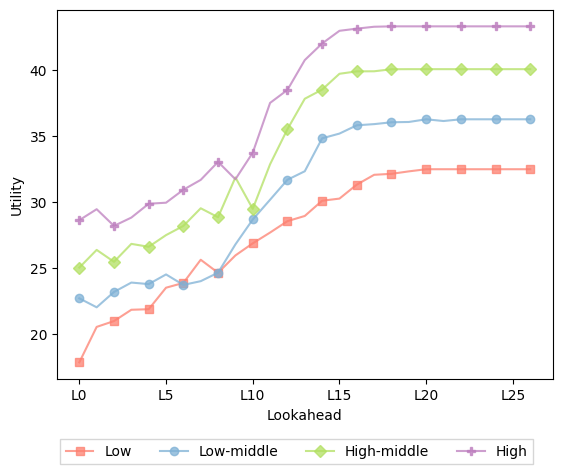

In [8]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
final_util.plot(ax=ax,legend=False)
lines, labels = ax.get_legend_handles_labels()
labels = ["Low","Low-middle","High-middle","High"]
ax.set_xlabel('Lookahead')
ax.set_ylabel('Utility')
marker = ['s','o', 'D', 'P']
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker[i])
    line.set_markevery(2)
    line.set_color(colors[i])
    line.set_alpha(0.75)
fig.legend(lines, labels,loc='upper center', bbox_to_anchor=(0.5, 0.00),fancybox=False, shadow=False, ncol=4)
plt.show()

## Standard Deviation of Volatality

In [9]:
assets = 123.76
income_pairs = [[0.0012237803762814433,1.125491495],[1.125491495,2.24975921],[2.24975921,3.374026925],[3.374026925,4.49829463984328]]

In [10]:
from subprocess import call,run
import glob
import os
import numpy as np
import pandas as pd

def utility_func(cons):
  return np.sqrt(cons)

def getUtility(beta,consumption):
  n = len(consumption)
  utilities = []
  for i in range(n):
    cons_row = consumption.iloc[i]
    utility = [utility_func(cons_row[0])]
    for i in range(1,len(cons_row)):
      util = utility[-1]+(beta**i)*utility_func(cons_row[i])
      utility.append(util)
    utilities.append(utility)
  utilities = np.array(utilities)
  return pd.DataFrame(data=utilities)

In [11]:
n = len(income_pairs)
data = []
#filt = [3,13,15]
lookaheads = 27
rt = ["0.9","1.1"]
sch = ["-0.6264","-0.0936"]
beta = "0.95"
for i in range(n):#filt:
  init_assets = str(assets)
  inc1 = str(income_pairs[i][0])
  inc2 = str(income_pairs[i][1])
  call(["gcc","stochastic.c","-o","stochastic.out","-lm"])
  tmp=run(["./stochastic.out", init_assets,inc1,inc2,rt[0],rt[1],sch[0],sch[1],beta,seed],capture_output = True)
  print(tmp)

  call(["gcc","lookahead.c","-o","lookahead.out","-lm"])
  for j in range(lookaheads):
    tmp=run(["./lookahead.out", init_assets,str(j),beta],capture_output = True)
    print(tmp)

  consumption = pd.read_csv("RuntimeData-Online-Consumption.csv",header=None).dropna(axis=1)
  utility = getUtility(0.95,consumption)
  data.append(utility[utility.columns[-1]].to_numpy())
  for clean_up in glob.glob('/content/*.*'):
          if not (clean_up.endswith('.c') or ("final_util" in clean_up)):
              os.remove(clean_up)

data = np.array(data)
indexes = ["L"+str(i) for i in range(27)]
final_util = pd.DataFrame(data=data.T,index=indexes)
final_util.to_csv("final_util-asst.csv")

CompletedProcess(args=['./stochastic.out', '123.76', '0.0012237803762814433', '1.125491495', '0.9', '1.1', '-0.6264', '-0.0936', '0.95', '1111'], returncode=0, stdout=b'T-26 and D-1548\nLowest value-0\nt=1, x=123\nt=2, x=0\nt=3, x=0\nt=4, x=0\nt=5, x=0\nt=6, x=0\nt=7, x=0\nt=8, x=0\nt=9, x=0\nt=10, x=0\nt=11, x=0\nt=12, x=0\nt=13, x=0\nt=14, x=0\nt=15, x=0\nt=16, x=0\nt=17, x=0\nt=18, x=0\nt=19, x=0\nt=20, x=0\nt=21, x=0\nt=22, x=0\nt=23, x=0\nt=24, x=0\nt=25, x=0\nt=26, x=0\nt=26, x=1\nt=25, x=1\nt=26, x=2\nt=24, x=1\nt=25, x=2\nt=26, x=3\nt=23, x=1\nt=24, x=2\nt=25, x=3\nt=26, x=4\nt=22, x=1\nt=23, x=2\nt=24, x=3\nt=25, x=4\nt=26, x=5\nt=21, x=1\nt=22, x=2\nt=23, x=3\nt=24, x=4\nt=25, x=5\nt=26, x=6\nt=26, x=7\nt=20, x=1\nt=21, x=2\nt=22, x=3\nt=23, x=4\nt=24, x=5\nt=25, x=6\nt=26, x=8\nt=19, x=1\nt=20, x=2\nt=21, x=3\nt=22, x=4\nt=23, x=5\nt=24, x=6\nt=25, x=7\nt=26, x=9\nt=18, x=1\nt=19, x=2\nt=20, x=3\nt=21, x=4\nt=22, x=5\nt=23, x=6\nt=24, x=7\nt=25, x=8\nt=26, x=10\nt=22, x=6\nt

In [12]:
final_util.T.describe()

,L0,L1,L2,L3,L4,L5,L6,L7,L8,L9,...,L17,L18,L19,L20,L21,L22,L23,L24,L25,L26
count,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,...,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000,4.000000
mean,22.293750,22.618305,23.901056,25.054614,25.078667,25.963425,25.668371,27.274058,27.774403,28.588261,...,36.540130,36.608258,36.653420,36.663602,36.674307,36.674307,36.674307,36.674307,36.674307,36.674307
std,3.465349,2.907298,2.570505,2.500594,2.843782,3.066107,2.449979,2.175876,2.777313,2.425473,...,4.084225,3.977953,3.995606,3.979942,3.963520,3.963520,3.963520,3.963520,3.963520,3.963520
min,17.742018,19.532913,21.809301,22.460266,22.069334,23.316829,23.097725,25.171698,25.099201,26.205486,...,31.721899,31.994411,32.037086,32.077813,32.120633,32.120633,32.120633,32.120633,32.120633,32.120633
25%,20.783747,20.554117,22.439397,23.613860,23.229183,23.382083,24.511356,25.508763,25.869021,26.781781,...,34.130403,34.198530,34.235221,34.245403,34.256108,34.256108,34.256108,34.256108,34.256108,34.256108
50%,22.768991,22.555289,23.093041,24.710334,24.846318,25.615232,25.300950,27.384048,27.331291,28.365590,...,36.671762,36.671762,36.689111,36.689111,36.689111,36.689111,36.689111,36.689111,36.689111,36.689111
75%,24.278994,24.619477,24.554701,26.151088,26.695802,28.196574,26.457965,29.149342,29.236673,30.172070,...,39.081490,39.081490,39.107309,39.107309,39.107309,39.107309,39.107309,39.107309,39.107309,39.107309
max,25.894998,25.829727,27.608843,28.337521,28.552696,29.306406,28.973857,29.156438,31.335828,31.416379,...,41.095098,41.095098,41.198374,41.198374,41.198374,41.198374,41.198374,41.198374,41.198374,41.198374


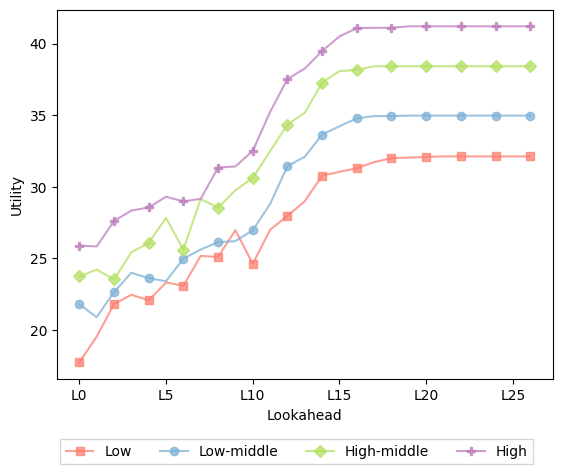

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
final_util.plot(ax=ax,legend=False)
lines, labels = ax.get_legend_handles_labels()
labels = ["Low","Low-middle","High-middle","High"]
ax.set_xlabel('Lookahead')
ax.set_ylabel('Utility')
marker = ['s','o', 'D', 'P']
colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe"]
for i, line in enumerate(ax.get_lines()):
    line.set_marker(marker[i])
    line.set_markevery(2)
    line.set_color(colors[i])
    line.set_alpha(0.75)
fig.legend(lines, labels,loc='upper center', bbox_to_anchor=(0.5, 0.00),fancybox=False, shadow=False, ncol=4)
plt.show()